In deep learning, datasets and models are usually large, which involves heavy computation. Therefore, computational performance matters a lot. This chapter will focus on the major factors that affect computational performance: 
 - Imperative programming
 - Symbolic programming
 - Asynchronous computing
 - Automatic parallelism
 - Multi-GPU computation

# 13.1 Compilers and Interpreters

So far, this book has focused on imperative programming, which makes use of statements such as print, +, and if to change a program's state. Consider a following example of a simple imperative program. 

In [1]:
def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
    
print(fancy_func(1, 2, 3, 4))

10


Python is an interpreted language. When evaluating the above fancy_func function it performs the operations making up the function’s body in sequence. That is, it will evaluate e = add(a, b) and store the results as variable e, thereby changing the program’s state. The next two statements f = add(c, d) and g = add(e, f) will be executed similarly, performing additions and storing the results as variables. The following figure illustrates the flow of data.

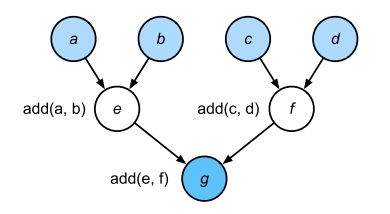

Although imperative programming is convenient, it may be inefficient. On the one hand, even if the add function is repeatedly called throughout fancy_func, Python will execute the three function calls individually. If these are executed, say, on a GPU (or even on multiple GPUs), the overhead arising from the Python interpreter can become overwhelming. Moreover, it will need to save the variable values of e and f until all the statements in fancy_func have been executed. This is because we do not know whether the variables e and f will be used by other parts of the program after the statements e = add(a, b) and f = add(c, d) are executed.

## 13.1.1 Symbolic Programming

Consider the alternative, symbolic programming, where computation is usually performed only once the process has been fully defined. This strategy is used by multiple deep learning frameworks, including Theano and TensorFlow (the latter has acquired imperative extensions). It usually involves the following steps:

 - Define the operations to be executed
 - Compile the operations into an executable program
 - Provide the required inputs and call the compiled program for execution

This allows for a significant amount of optimization. First, we can skip the Python interpreter in many cases, thus removing a performance bottleneck that can become significant on multiple fast GPUs paired with a single Python thread on a CPU. Second, a compiler might optimize and rewrite the above code into print((1 + 2) + (3 + 4)) or even print(10). To get a better idea, consider the following simulation of imperative programming (it is Python after all) below.

In [8]:
def add_():
    return '''
def add(a, b):
    return a + b
'''

def fancy_func_():
    return '''
def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
    '''
def evoke_():
    return add_() + fancy_func_() + 'print(fancy_func(1, 2, 3, 4))'

prog = evoke_()
print(prog)
y = compile(prog, '', 'exec')
exec(y)


def add(a, b):
    return a + b

def fancy_func(a, b, c, d):
    e = add(a, b)
    f = add(c, d)
    g = add(e, f)
    return g
    print(fancy_func(1, 2, 3, 4))


## 13.1.2 Hybrid Programming

Historically most deep learning frameworks choose between an imperative or a symbolic approach. As mentioned above, PyTorch is based on imperative programming and uses dynamic computation graphs. In an effort to leverage the portability and efficiency of symbolic programming, developers considered whether it would be possible to combine the benefits of both programming paradigms. This led to a torchscript that lets users develop and debug using pure imperative programming, while having the ability to convert most programs into symbolic programs to be run when product-level computing performance and deployment are required.

## 13.1.3 Hybridizing the Sequential Class

The easiest way to get a feel for how hybridization works is to consider deep networks with multiple layers. Conventionally the Python interpreter will need to execute the code for all layers to generate an instruction that can then be forwarded to a CPU or a GPU. For a single (fast) computing device this does not cause any major issues. On the other hand, if we use an advanced 8-GPU server such as an AWS P3dn.24xlarge instance Python will struggle to keep all GPUs busy. The single-threaded Python interpreter becomes the bottleneck here. Let’s see how we can address this for significant parts of the code by replacing Sequential with HybridSequential. We begin by defining a simple MLP.

In [9]:
import torch
from torch import nn
from d2l import torch as d2l
# Factory for networks
def get_net():
    net = nn.Sequential(nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 2))
    return net

x = torch.randn(size=(1, 512))
net = get_net()
net(x)

tensor([[-0.0466,  0.2070]], grad_fn=<AddmmBackward0>)

By converting the model using torch.jit.script function, we are able to compile and optimize the computation in the MLP. The model’s computation result remains unchanged.

In [10]:
net = torch.jit.script(net)
net(x)

tensor([[-0.0466,  0.2070]], grad_fn=<AddmmBackward0>)

### Acceleartion by Hybridization

In [11]:
#@save
class Benchmark:
    """For measuring running time."""
    def __init__(self, description='Done'):
        self.description = description
    def __enter__(self):
        self.timer = d2l.Timer()
        return self
    def __exit__(self, *args):
        print(f'{self.description}: {self.timer.stop():.4f} sec')

In [12]:
net = get_net()
with Benchmark('Without torchscript'):
    for i in range(1000): net(x)
net = torch.jit.script(net)
with Benchmark('With torchscript'):
    for i in range(1000): net(x)

Without torchscript: 0.8653 sec
With torchscript: 0.8492 sec


One of the benefits of compiling the models is that we can serialize (save) the model and its parameters to disk. This allows us to store a model in a manner that is independent of the front-end language of choice.

In [13]:
net.save('my_mlp')